#### Importing basic libraries

In [1]:
#importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

import os
import zipfile
import shutil
import re

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Bidirectional

Tensorflow version: 2.8.2
Keras version: 2.8.0


#### Downloading the Dataset

In [5]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d columbine/imdb-dataset-sentiment-analysis-in-csv-format

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 35% 9.00M/25.7M [00:00<00:00, 86.6MB/s]
100% 25.7M/25.7M [00:00<00:00, 177MB/s] 


In [6]:
local_zip = '/content/imdb-dataset-sentiment-analysis-in-csv-format.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [7]:
train_df = pd.read_csv("/tmp/Train.csv")
test_df = pd.read_csv("/tmp/Test.csv")
validation_df = pd.read_csv("/tmp/Valid.csv")

In [8]:
test_df.head()

,text,label
0,I always wrote this series off as being a comp...,0
1,1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...,0
2,This movie was so poorly written and directed ...,0
3,The most interesting thing about Miryang (Secr...,1
4,"when i first read about ""berlin am meer"" i did...",0


In [9]:
#this is to see the dsitribution of the positive and negative sentiment
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

0    20019
1    19981
Name: label, dtype: int64
1    2505
0    2495
Name: label, dtype: int64


In [10]:
train_df["text"][0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

#### Preprocessing

In [11]:
#converting to lower case
def convert_lowercase(column):
    column = column.str.lower()
    return column

In [12]:
#removing  urls
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

In [13]:
#removing html tags if present
def clean_html(text):
    clean=re.compile('<.*?>')
    return re.sub(clean, '', text)

In [14]:
#removing special characters
import string
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

In [15]:
#removing stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_english = stopwords.words('english')

def remove_stopwords(text):
    new_text = []
    for word in text.split():
        if word in stopwords_english:
            continue
        else:
            new_text.append(word)

    return ' '.join(new_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
!pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()

def remove_spelling_error(text):
  return spell.correction(text)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 4.0 MB/s 


##### Train Data Preprocessing

In [17]:
train_df['text']=convert_lowercase(train_df['text'])
train_df['text']=train_df['text'].apply(remove_url)
train_df['text']=train_df['text'].apply(clean_html)
train_df['text']=train_df['text'].apply(remove_punc)
train_df['text']=train_df['text'].apply(remove_stopwords)
train_df['text']=train_df['text'].apply(remove_spelling_error)

##### Test Data Preprocessing

In [18]:
test_df['text']=convert_lowercase(test_df['text'])
test_df['text']=test_df['text'].apply(remove_url)
test_df['text']=test_df['text'].apply(clean_html)
test_df['text']=test_df['text'].apply(remove_punc)
test_df['text']=test_df['text'].apply(remove_stopwords)

##### Validation Data Preprocessing

In [19]:
validation_df['text']=convert_lowercase(validation_df['text'])
validation_df['text']=validation_df['text'].apply(remove_url)
validation_df['text']=validation_df['text'].apply(clean_html)
validation_df['text']=validation_df['text'].apply(remove_punc)
validation_df['text']=validation_df['text'].apply(remove_stopwords)
#validation_df['text']=validation_df['text'].apply(remove_spelling_error)

#### Tokenization and Lemmatization

In [20]:
import nltk
nltk.download('punkt')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
nltk.download('omw-1.4')
import spacy
nlp = spacy.load("en_core_web_sm")
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

i = 0
def tokenize_lemmatize(x):
    if x == None:
        return " "
    doc = nlp(x)
    x = [token.lemma_ for token in doc]
    x = " ".join(x)
    x = word_tokenize(x)
    
    global i
    i+=1
    if i % 1000 == 0:
        print(f'{i} ')
    
    return x

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [21]:
train_df['text']=train_df['text'].apply(tokenize_lemmatize)
validation_df['text']=validation_df['text'].apply(tokenize_lemmatize)
test_df['text']=test_df['text'].apply(tokenize_lemmatize)

1000 
2000 
3000 
4000 
5000 
6000 
7000 
8000 
9000 
10000 
11000 
12000 
13000 
14000 
15000 
16000 
17000 
18000 
19000 
20000 
21000 
22000 
23000 
24000 
25000 
26000 
27000 
28000 
29000 
30000 
31000 
32000 
33000 
34000 
35000 
36000 
37000 
38000 
39000 
40000 
41000 
42000 
43000 
44000 
45000 
46000 
47000 
48000 
49000 


#### Most common words visualization

In [ ]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(x, n=None):
    final_text = []
    for text in x:
        temp = " ".join(text)
        final_text.append(temp)
    vec = CountVectorizer(stop_words='english').fit(final_text)
    bag_of_words = vec.transform(final_text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda final_text: final_text[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words = get_top_n_words(train_df["text"], 20)
common_words

[('movie', 79318),
 ('film', 73410),
 ('make', 34766),
 ('like', 34404),
 ('good', 30667),
 ('time', 23362),
 ('character', 22092),
 ('watch', 20814),
 ('bad', 20047),
 ('story', 19334),
 ('really', 18391),
 ('think', 17587),
 ('scene', 16474),
 ('great', 15567),
 ('look', 15149),
 ('say', 15118),
 ('know', 14842),
 ('people', 14421),
 ('end', 13556),
 ('love', 13467)]

In [ ]:
dfu = pd.DataFrame(common_words, columns = ['Unigram Text', 'Count'])
dfu
dfu.groupby('Unigram Text').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='The distribution of Top 20 Unigram')

In [ ]:
def get_top_n_bigram(x, n=None):
    final_text = []
    for text in x:
        temp = " ".join(text)
        final_text.append(temp)
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(final_text)
    bag_of_words = vec.transform(final_text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda final_text: final_text[1], reverse=True)
    return words_freq[:n]

In [ ]:
common_words = get_top_n_bigram(train_df["text"], 20)
common_words

[('look like', 3081),
 ('watch movie', 2391),
 ('bad movie', 2113),
 ('movie make', 2016),
 ('make movie', 1904),
 ('film make', 1789),
 ('special effect', 1755),
 ('movie like', 1744),
 ('good movie', 1737),
 ('make film', 1550),
 ('main character', 1514),
 ('feel like', 1381),
 ('waste time', 1375),
 ('year old', 1338),
 ('watch film', 1285),
 ('film like', 1264),
 ('horror movie', 1218),
 ('good film', 1202),
 ('horror film', 1131),
 ('like movie', 1124)]

In [ ]:
df2 = pd.DataFrame(common_words, columns = ['Bigram Text', 'Count'])
df2
df2.groupby('Bigram Text').sum()['Count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='The distribution of Top 20 Bigram')

##### Sentiment Words

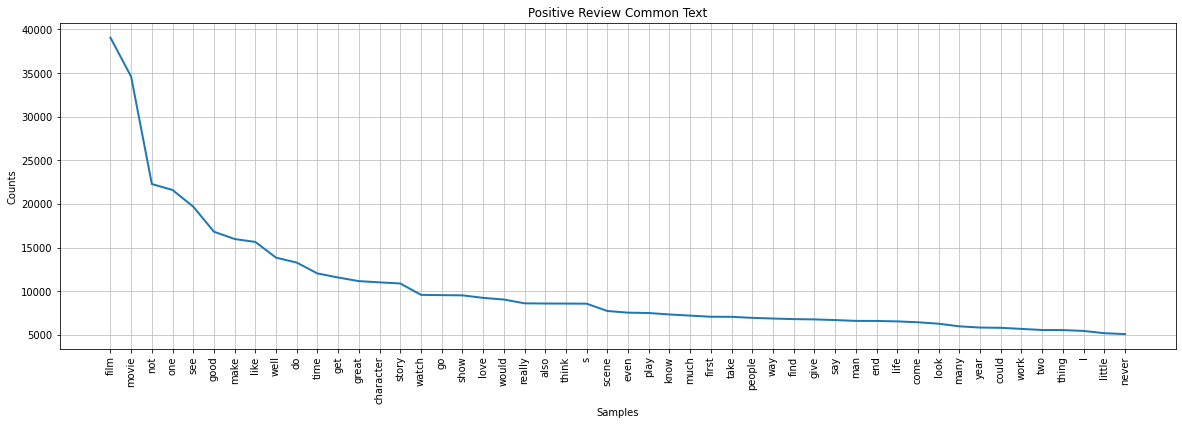

In [ ]:
from nltk.probability import FreqDist
txt = train_df[train_df['label'] == 1].text
final_text = []
for text in txt:
    temp = " ".join(text)
    final_text.append(temp)
pos_freq = FreqDist(' '.join(final_text).split(' '))
plt.figure(figsize=(20,6))
pos_freq.plot(50,cumulative=False,title='Positive Review Common Text')
plt.show()

#### Splitting into Train and Test Data

In [22]:
x_train = train_df['text']
y_train = train_df['label']

x_test = test_df['text']
y_test = test_df['label']

x_valid = validation_df['text']
y_valid = validation_df['label']

In [23]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()

tokenizer.fit_on_texts(x_train)

#tokenizing i.e. converting words to integer sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_valid = tokenizer.texts_to_sequences(x_valid)

#preparing sequences of the same length
x_train = pad_sequences(x_train,maxlen = 512,padding='post',truncating='post')
x_test = pad_sequences(x_test,maxlen = 512,padding='post',truncating='post')

In [24]:
num_words = len(tokenizer.word_index)+1
print(num_words)

177983


#### LSTM

In [25]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim=64,input_length=512,trainable=True))

#model.add(LSTM(100,dropout=0.2,return_sequences=True))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64, return_sequences=True)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(tf.keras.layers.LSTM(units = 64)) 
model_lstm.add(Dropout(0.2))

model_lstm.add(Dense(units=1,activation='sigmoid'))

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 64)           11390912  
                                                                 
 lstm (LSTM)                 (None, 512, 64)           33024     
                                                                 
 dropout (Dropout)           (None, 512, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 512, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 512, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 512, 64)           33024     
                                                                 
 dropout_2 (Dropout)         (None, 512, 64)           0

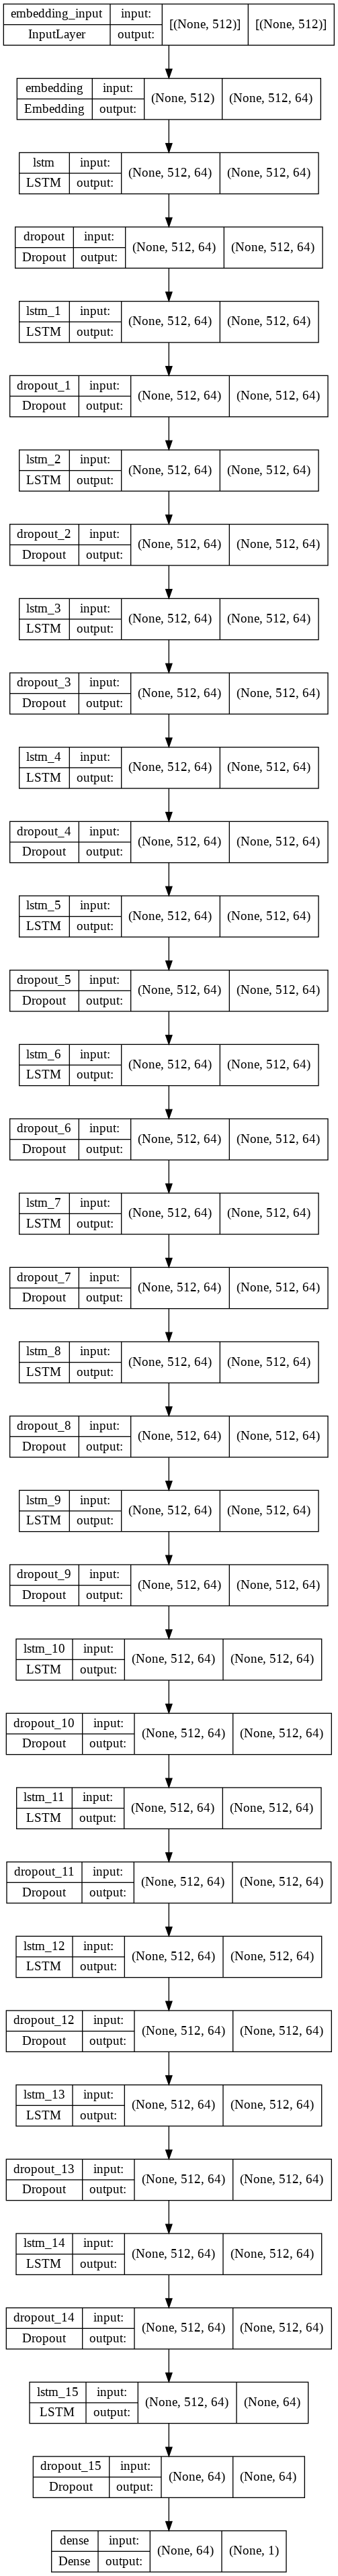

In [ ]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [26]:
model_lstm.fit(x_train, y_train,batch_size = 64)

625/625 [==============================] - 188s 264ms/step - loss: 0.6934 - accuracy: 0.4998


In [ ]:
score, acc = model_lstm.evaluate(x_test, y_test)
print('Test Accuracy: {}%'.format(acc*100))
print('Test Score: {}%'.format(score*100))

157/157 [==============================] - 20s 97ms/step - loss: 0.6931 - accuracy: 0.5010
Test Accuracy: 50.09999871253967%
Test Score: 69.31496858596802%


#### BidRNN

In [ ]:
model_brnn = Sequential()
model_brnn.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim=64,input_length=512,trainable=True))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn.add(Dropout(0.2))

model_brnn.add(Dense(units=1,activation='sigmoid'))

model_brnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_brnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 64)           11390912  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 128)         16512     
 l)                                                              
                                                                 
 dropout_16 (Dropout)        (None, 512, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 128)         24704     
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 512, 128)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 512, 128)        

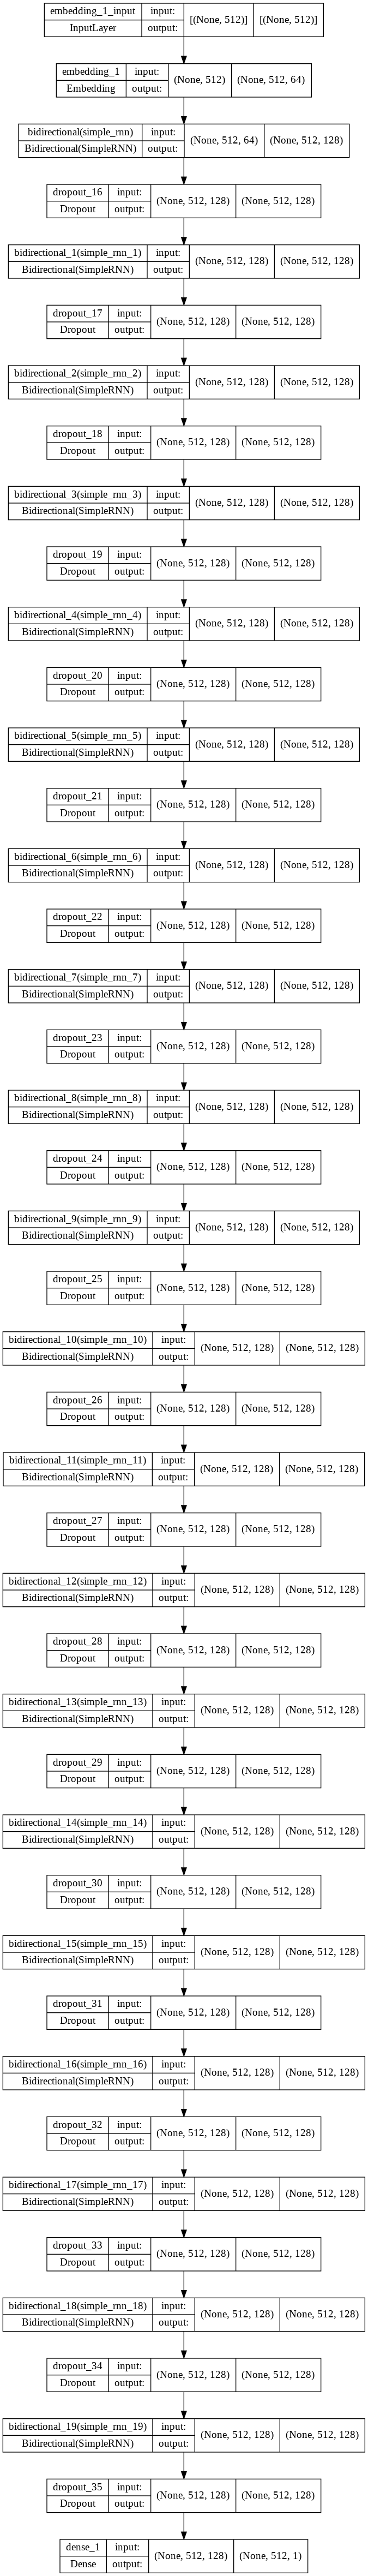

In [ ]:
plot_model(model_brnn, show_shapes=True, show_layer_names=True)

In [ ]:
# above architecture was not run again as it would take an aprox 4hrs30min to fit. The model was compiled in the inital document in which the test data was not padded hence was not evaluated 

In [27]:
model_brnn_ = Sequential()
model_brnn_.add(tf.keras.layers.Embedding(input_dim=num_words,output_dim=64,input_length=512,trainable=True))

model_brnn_.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn_.add(Dropout(0.2))

model_brnn_.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn_.add(Dropout(0.2))

model_brnn_.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn_.add(Dropout(0.2))

model_brnn_.add(Bidirectional(SimpleRNN(units = 64, activation = "tanh", return_sequences = True)))
model_brnn_.add(Dropout(0.2))

model_brnn_.add(Dense(units=1,activation='sigmoid'))

model_brnn_.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_brnn_.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 512, 64)           11390912  
                                                                 
 bidirectional (Bidirectiona  (None, 512, 128)         16512     
 l)                                                              
                                                                 
 dropout_16 (Dropout)        (None, 512, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 512, 128)         24704     
 nal)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 512, 128)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 512, 128)        

In [28]:
model_brnn_.fit(x_train, y_train,batch_size = 64,epochs=1)

625/625 [==============================] - 1677s 3s/step - loss: 0.6819 - accuracy: 0.5773


In [ ]:
score1, acc1 = model_brnn_.evaluate(x_test, y_test)
print('Test Accuracy: {}%'.format(acc1*100))
print('Test Score: {}%'.format(score1*100))

157/157 [==============================] - 45s 283ms/step - loss: 0.5987 - accuracy: 0.7013
Test Accuracy: 70.12523412704468%
Test Score: 59.870827198028564%


#### Dealing with custom input

In [31]:
validation_sentence = ['']
validation_sentence_tokened = tokenizer.texts_to_sequences(validation_sentence)
validation_sentence_padded = pad_sequences(validation_sentence_tokened,maxlen=512,truncating='post',padding='post')
#print(validation_sentence[0])
print("Possibility of Positive LSTM: {}".format(model_lstm.predict(validation_sentence_padded)))
print("Possibility of Positive BDRNN: {}".format(model_brnn_.predict(validation_sentence_padded)))

Possibility of Positive LSTM: [[0.5029533]]
Possibility of Positive BDRNN: [[[0.33987993]
  [0.3538172 ]
  [0.32744005]
  [0.37426588]
  [0.36293218]
  [0.41518945]
  [0.4082141 ]
  [0.45093566]
  [0.45206916]
  [0.48628494]
  [0.4811998 ]
  [0.49863273]
  [0.49071983]
  [0.49602568]
  [0.49084195]
  [0.49521622]
  [0.49022576]
  [0.49628845]
  [0.49088764]
  [0.4969446 ]
  [0.49098647]
  [0.4971631 ]
  [0.4911202 ]
  [0.4972936 ]
  [0.49113756]
  [0.49733672]
  [0.4911386 ]
  [0.49733388]
  [0.4911232 ]
  [0.4973321 ]
  [0.4911151 ]
  [0.4973295 ]
  [0.49111262]
  [0.49732643]
  [0.49111256]
  [0.4973262 ]
  [0.49111238]
  [0.4973262 ]
  [0.4911125 ]
  [0.49732614]
  [0.4911125 ]
  [0.49732614]
  [0.4911125 ]
  [0.4973262 ]
  [0.4911125 ]
  [0.4973262 ]
  [0.4911125 ]
  [0.4973262 ]
  [0.49111256]
  [0.4973262 ]
  [0.4911125 ]
  [0.4973262 ]
  [0.4911125 ]
  [0.4973262 ]
  [0.4911125 ]
  [0.4973262 ]
  [0.4911125 ]
  [0.4973262 ]
  [0.4911125 ]
  [0.4973262 ]
  [0.4911125 ]
  [0.49732

In [30]:
validation_sentence = ['The film borrows from Indian mythology and folk tales, which is fantastic. The effort and passion invested in creating the universe in this film, replete with minute detailing, are worthy of appreciation. And while doing so, the makers lovingly doff their hats to movies like the Harry Potter franchise. The film shines in divisions like the VFX. The film’s colour palette has been created thoughtfully, and the depiction of the astras created out of the powers of nature and mythological characters is beautiful. The action choreography, especially in the chase sequence before interval, deserves whistles and claps, too.']
validation_sentence_tokened = tokenizer.texts_to_sequences(validation_sentence)
validation_sentence_padded = pad_sequences(validation_sentence_tokened,maxlen=512,truncating='post',padding='post')
#print(validation_sentence[0])
print("Possibility of Positive LSTM: {}".format(model_lstm.predict(validation_sentence_padded)[0]))
print("Possibility of Positive BDRNN: {}".format(model_brnn_.predict(validation_sentence_padded)[0]))

Possibility of Positive LSTM: [0.5029533]
Possibility of Positive BDRNN: [[0.33886343]
 [0.3617575 ]
 [0.33690673]
 [0.39590272]
 [0.3907639 ]
 [0.4496771 ]
 [0.46365398]
 [0.49410713]
 [0.48972034]
 [0.48422804]
 [0.47271752]
 [0.48696077]
 [0.4948897 ]
 [0.5072316 ]
 [0.50384486]
 [0.52638245]
 [0.5237531 ]
 [0.53858286]
 [0.5320155 ]
 [0.55672014]
 [0.5449759 ]
 [0.5621819 ]
 [0.54073334]
 [0.5666524 ]
 [0.5575889 ]
 [0.579993  ]
 [0.56487507]
 [0.5807194 ]
 [0.5517396 ]
 [0.5720037 ]
 [0.5461185 ]
 [0.56612676]
 [0.5416275 ]
 [0.5604028 ]
 [0.5443536 ]
 [0.561622  ]
 [0.5470649 ]
 [0.57202977]
 [0.55396426]
 [0.57166123]
 [0.5454448 ]
 [0.56463295]
 [0.5455185 ]
 [0.56337655]
 [0.5483489 ]
 [0.57729304]
 [0.56742346]
 [0.6010084 ]
 [0.58273834]
 [0.6186211 ]
 [0.59163785]
 [0.62336886]
 [0.59484965]
 [0.6237659 ]
 [0.5962299 ]
 [0.6253204 ]
 [0.59691024]
 [0.6254867 ]
 [0.59204674]
 [0.619613  ]
 [0.59078306]
 [0.61789817]
 [0.5892726 ]
 [0.61405575]
 [0.58484256]
 [0.6003464 ]
 [0

In [ ]:
model_lstm.save('model_lstm')
model_brnn_.save('model_brnn_')

In [33]:
test2 = pd.read_csv('test_data.csv')
test2.head()

,text,label
0,I never read the book. Maybe that's why I real...,1
1,Got me hooked and depressed at the same time. ...,1
2,A good story made for young and no so young. I...,1
3,The Movie is absolute trash..only idiot salman...,0
4,"reduced characters to caricatures, didn't earn...",0


In [34]:
test2['text']=convert_lowercase(test2['text'])
test2['text']=test2['text'].apply(remove_url)
test2['text']=test2['text'].apply(clean_html)
test2['text']=test2['text'].apply(remove_punc)
test2['text']=test2['text'].apply(remove_stopwords)
test2['text']=test2['text'].apply(remove_spelling_error)

In [35]:
test2['text']=test2['text'].apply(tokenize_lemmatize)

50000 


In [36]:
x = test2['text']
y = test2['label']
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen = 512,padding='post',truncating='post')

In [37]:
testloss1, testacc1 = model_lstm.evaluate(x, y)

1/1 [==============================] - 6s 6s/step - loss: 0.6932 - accuracy: 0.5000


In [39]:
from sklearn.metrics import classification_report
pred_test1 = model_lstm.predict(x)
pred_test1[pred_test1>0.5] = 1
pred_test1[pred_test1<=0.5] = 0
print(classification_report(y, pred_test1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.50      1.00      0.67         5

    accuracy                           0.50        10
   macro avg       0.25      0.50      0.33        10
weighted avg       0.25      0.50      0.33        10



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
testloss2, testacc2 = model_brnn_.evaluate(x, y)

1/1 [==============================] - 1s 1s/step - loss: 0.6895 - accuracy: 0.5164


In [ ]:
pred_test2 = model_brnn_.predict(x)
pred_test2[pred_test2>0.5] = 1
pred_test2[pred_test2<=0.5] = 0
print(classification_report(y, pred_test2))

In [44]:
import tabulate
table = [['Model', 'Loss', 'Accuracy'],
         ['LSTM', testloss1, testacc1],
         ['BidRNN', testloss2, testacc2]]

print(tabulate.tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════╤══════════╤════════════╕
│ Model   │     Loss │   Accuracy │
╞═════════╪══════════╪════════════╡
│ LSTM    │ 0.693165 │   0.5      │
├─────────┼──────────┼────────────┤
│ BidRNN  │ 0.689525 │   0.516406 │
╘═════════╧══════════╧════════════╛


From the above inference we conclude that both the models perform equally well with respect to unknown data.